# Load library

In [1]:
import gc
import os
import logging
import datetime
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import lightgbm as lgb
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import StratifiedKFold
warnings.filterwarnings('ignore')

# Load data

In [2]:
train_df = pd.read_csv("./train.csv")
test_df = pd.read_csv("./test.csv")

# Feature Engineering

## row별로, 피쳐들의 값을 sum, min, max... 한 값들이 
* target 0 vs 1 에 대해서, 서로 다른 분포를 가지더라
* 즉, 좋은 피쳐가 될 확률이 높다

In [3]:
idx = features = train_df.columns.values[2:202]
for df in [test_df, train_df]:
    df['sum'] = df[idx].sum(axis=1)  
    df['min'] = df[idx].min(axis=1)
    df['max'] = df[idx].max(axis=1)
    df['mean'] = df[idx].mean(axis=1)
    df['std'] = df[idx].std(axis=1)
    df['skew'] = df[idx].skew(axis=1)
    df['kurt'] = df[idx].kurtosis(axis=1)
    df['med'] = df[idx].median(axis=1)

In [4]:
train_df[['target','var_0','var_1','sum','min','med']].head(5)

target    var_0   var_1        sum      min      med
0       0   8.9255 -6.7863  1456.3182 -21.4494  6.77040
1       0  11.5006 -4.1473  1415.3636 -47.3797  7.22315
2       0   8.6093 -2.7457  1240.8966 -22.4038  5.89940
3       0  11.0604 -2.1518  1288.2319 -35.1659  6.70260
4       0   9.8369 -1.4834  1354.2310 -65.4863  6.94735

In [6]:
test_df[['var_0','var_1','sum','min','med']].head(2)

var_0   var_1        sum      min     med
0  11.0656  7.7798  1416.6404 -31.9891  7.3144
1   8.5304  1.2543  1249.6860 -41.1924  6.4396

In [7]:
def plot_new_feature_distribution(df1, df2, label1, label2, features):
    i = 0
    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(2,4,figsize=(18,8))

    for feature in features:
        i += 1
        plt.subplot(2,4,i)
        sns.kdeplot(df1[feature], bw=0.5,label=label1)
        sns.kdeplot(df2[feature], bw=0.5,label=label2)
        plt.xlabel(feature, fontsize=11)
        locs, labels = plt.xticks()
        plt.tick_params(axis='x', which='major', labelsize=8)
        plt.tick_params(axis='y', which='major', labelsize=8)
    plt.show();

### 이렇게 해서, 신규 피쳐 만들고 보니..
* sum, min, max는 특징이 보이고
* 나머지들은 크게 뭔가 딱히 보이진 않네...

<Figure size 432x288 with 0 Axes>

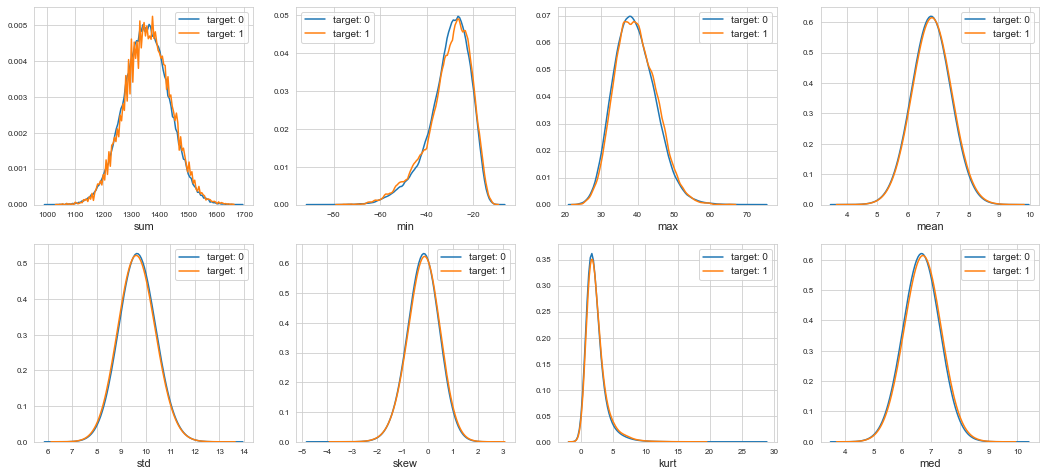

In [8]:
t0 = train_df.loc[train_df['target'] == 0]
t1 = train_df.loc[train_df['target'] == 1]
features = train_df.columns.values[202:]
plot_new_feature_distribution(t0, t1, 'target: 0', 'target: 1', features)

### train과 test셋의 분포는 비슷하니, 
* train 으로 만든 모델로, test셋에서 무리 없이 쓸 수 있겠구나 (데이터의 일관성이 있으니)

<Figure size 432x288 with 0 Axes>

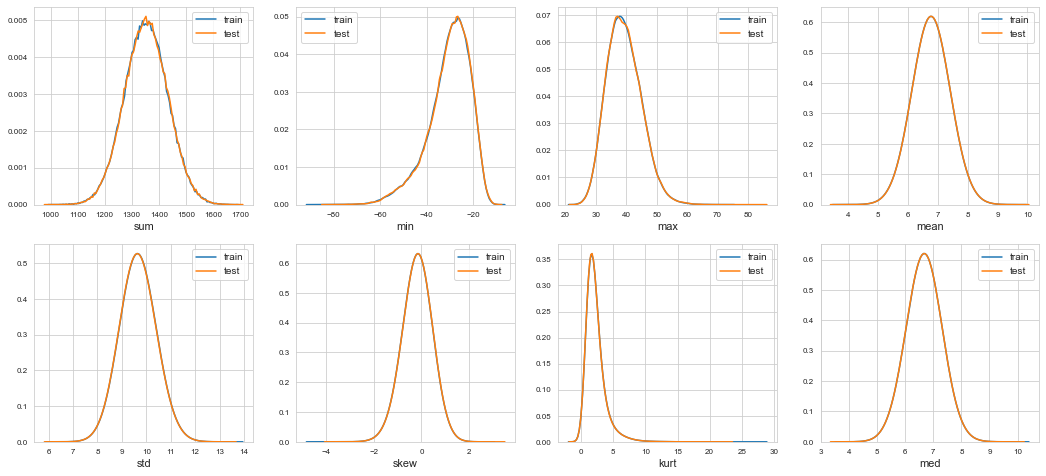

In [10]:
features = train_df.columns.values[202:]
plot_new_feature_distribution(train_df, test_df, 'train', 'test', features)

In [11]:
features = [c for c in train_df.columns if c not in ['ID_code', 'target']]
for feature in features:
    train_df['r2_'+feature] = np.round(train_df[feature], 2)
    test_df['r2_'+feature] = np.round(test_df[feature], 2)
    train_df['r1_'+feature] = np.round(train_df[feature], 1)
    test_df['r1_'+feature] = np.round(test_df[feature], 1)

In [13]:
train_df[['var_0','var_1','sum','std',
          'r1_var_0','r1_var_1','r1_sum','r1_std',
          'r2_var_0','r2_var_1','r2_sum','r2_std',]].head(3)

var_0   var_1        sum        std  r1_var_0  r1_var_1  r1_sum  r1_std  \
0   8.9255 -6.7863  1456.3182   9.331540       8.9      -6.8  1456.3     9.3   
1  11.5006 -4.1473  1415.3636  10.336130      11.5      -4.1  1415.4    10.3   
2   8.6093 -2.7457  1240.8966   8.753387       8.6      -2.7  1240.9     8.8   

   r2_var_0  r2_var_1   r2_sum  r2_std  
0      8.93     -6.79  1456.32    9.33  
1     11.50     -4.15  1415.36   10.34  
2      8.61     -2.75  1240.90    8.75

# Modeling

## pycaret

In [51]:
from pycaret.classification import *
clf1 = setup(train_df, target = 'target', 
             session_id=123, 
             train_size=0.9,
             fold=10,
             log_experiment=True, 
             fix_imbalance = True,
             silent=True,
             ignore_features=['ID_code'],
             experiment_name='santander1')

In [16]:
param = {
    'bagging_freq': 5,
    'bagging_fraction': 0.4,
    'boost_from_average':'false',
    'boost': 'gbdt',
    'feature_fraction': 0.05,
    'learning_rate': 0.01,
    'max_depth': -1,  
    'metric':'auc',
    'min_data_in_leaf': 80,
    'min_sum_hessian_in_leaf': 10.0,
    'num_leaves': 13,
    'num_threads': 8,
    'tree_learner': 'serial',
    'objective': 'binary', 
    'verbosity': 1
}

In [52]:
lightgbm = create_model('lightgbm',
                        bagging_freq=5,
                        bagging_fraction=0.4,
                        boost_from_average='false',
                        boost='gbdt',
                        feature_fraction=0.05,
                        learning_rate=0.01,
                        max_depth=-1,
                        metric='auc',
                        min_data_in_leaf=80,
                        min_sum_hessian_in_leaf=10.0,
                        num_leaves=13,
                        num_threads=8,
                        tree_learner='serial',
                        objective='binary',
                        verbosity=1,
                        num_round = 15000,
                        verbose_eval=1000, 
#                         early_stopping_rounds = 3000                        
                       )

In [21]:
lightgbm = create_model('lightgbm')

In [22]:
best = compare_models(include = ['catboost','lightgbm','xgboost'])

## 일반적인 방법
* pycaret은 fold=2로 했을때, auc 0.83 나왔고,
* fold=10으로 하니, auc 0.86이 최고였다
* pycaret의 SMOTE를 해도 auc 0.86으로 변화가 없었다
* 그러나, 일반적인 방법으로 lightgbm을 사용하니, auc 0.9가 나왔다. 왜일까?
* [LightGBM] [Info] Number of positive: 18089, number of negative: 161911

In [24]:
features = [c for c in train_df.columns if c not in ['ID_code', 'target']]
target = train_df['target']

In [25]:
folds = StratifiedKFold(n_splits=10, shuffle=False, random_state=44000)
oof = np.zeros(len(train_df))
predictions = np.zeros(len(test_df))
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train_df.values, target.values)):
    print("Fold {}".format(fold_))
    trn_data = lgb.Dataset(train_df.iloc[trn_idx][features], label=target.iloc[trn_idx])
    val_data = lgb.Dataset(train_df.iloc[val_idx][features], label=target.iloc[val_idx])

    num_round = 1000000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=1000, early_stopping_rounds = 3000)
    oof[val_idx] = clf.predict(train_df.iloc[val_idx][features], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += clf.predict(test_df[features], num_iteration=clf.best_iteration) / folds.n_splits

print("CV score: {:<8.5f}".format(roc_auc_score(target, oof)))

Fold 0
[LightGBM] [Info] Number of positive: 18089, number of negative: 161911
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004795 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141423
[LightGBM] [Info] Number of data points in the train set: 180000, number of used features: 623
Training until validation scores don't improve for 3000 rounds
[1000]	training's auc: 0.884918	valid_1's auc: 0.864213
[2000]	training's auc: 0.909624	valid_1's auc: 0.884243
[3000]	training's auc: 0.921362	valid_1's auc: 0.892335
[4000]	training's auc: 0.928678	valid_1's auc: 0.89594
[5000]	training's auc: 0.934318	valid_1's auc: 0.897778
[6000]	training's auc: 0.939229	valid_1's auc: 0.898686
[7000]	training's auc: 0.943703	valid_1's auc: 0.899388
[8000]	training's auc: 0.947934	valid_1's auc: 0.899702
[9000]	training's auc: 0.952017	valid_1's auc: 0.89

[11000]	training's auc: 0.959534	valid_1's auc: 0.900055
[12000]	training's auc: 0.963006	valid_1's auc: 0.899936
Early stopping, best iteration is:
[9453]	training's auc: 0.953686	valid_1's auc: 0.900302
Fold 7
[LightGBM] [Info] Number of positive: 18088, number of negative: 161912
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.629112 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 141407
[LightGBM] [Info] Number of data points in the train set: 180000, number of used features: 623
Training until validation scores don't improve for 3000 rounds
[1000]	training's auc: 0.88464	valid_1's auc: 0.865225
[2000]	training's auc: 0.90929	valid_1's auc: 0.885112
[3000]	training's auc: 0.921075	valid_1's auc: 0.892965
[4000]	training's auc: 0.928477	valid_1's auc: 0.896667
[5000]	training's auc: 0.93413	valid_1's auc: 0.89888
[6000]	training's auc: 0.938968	valid_1's auc: 0.899368
[7000]	training's auc: 0.

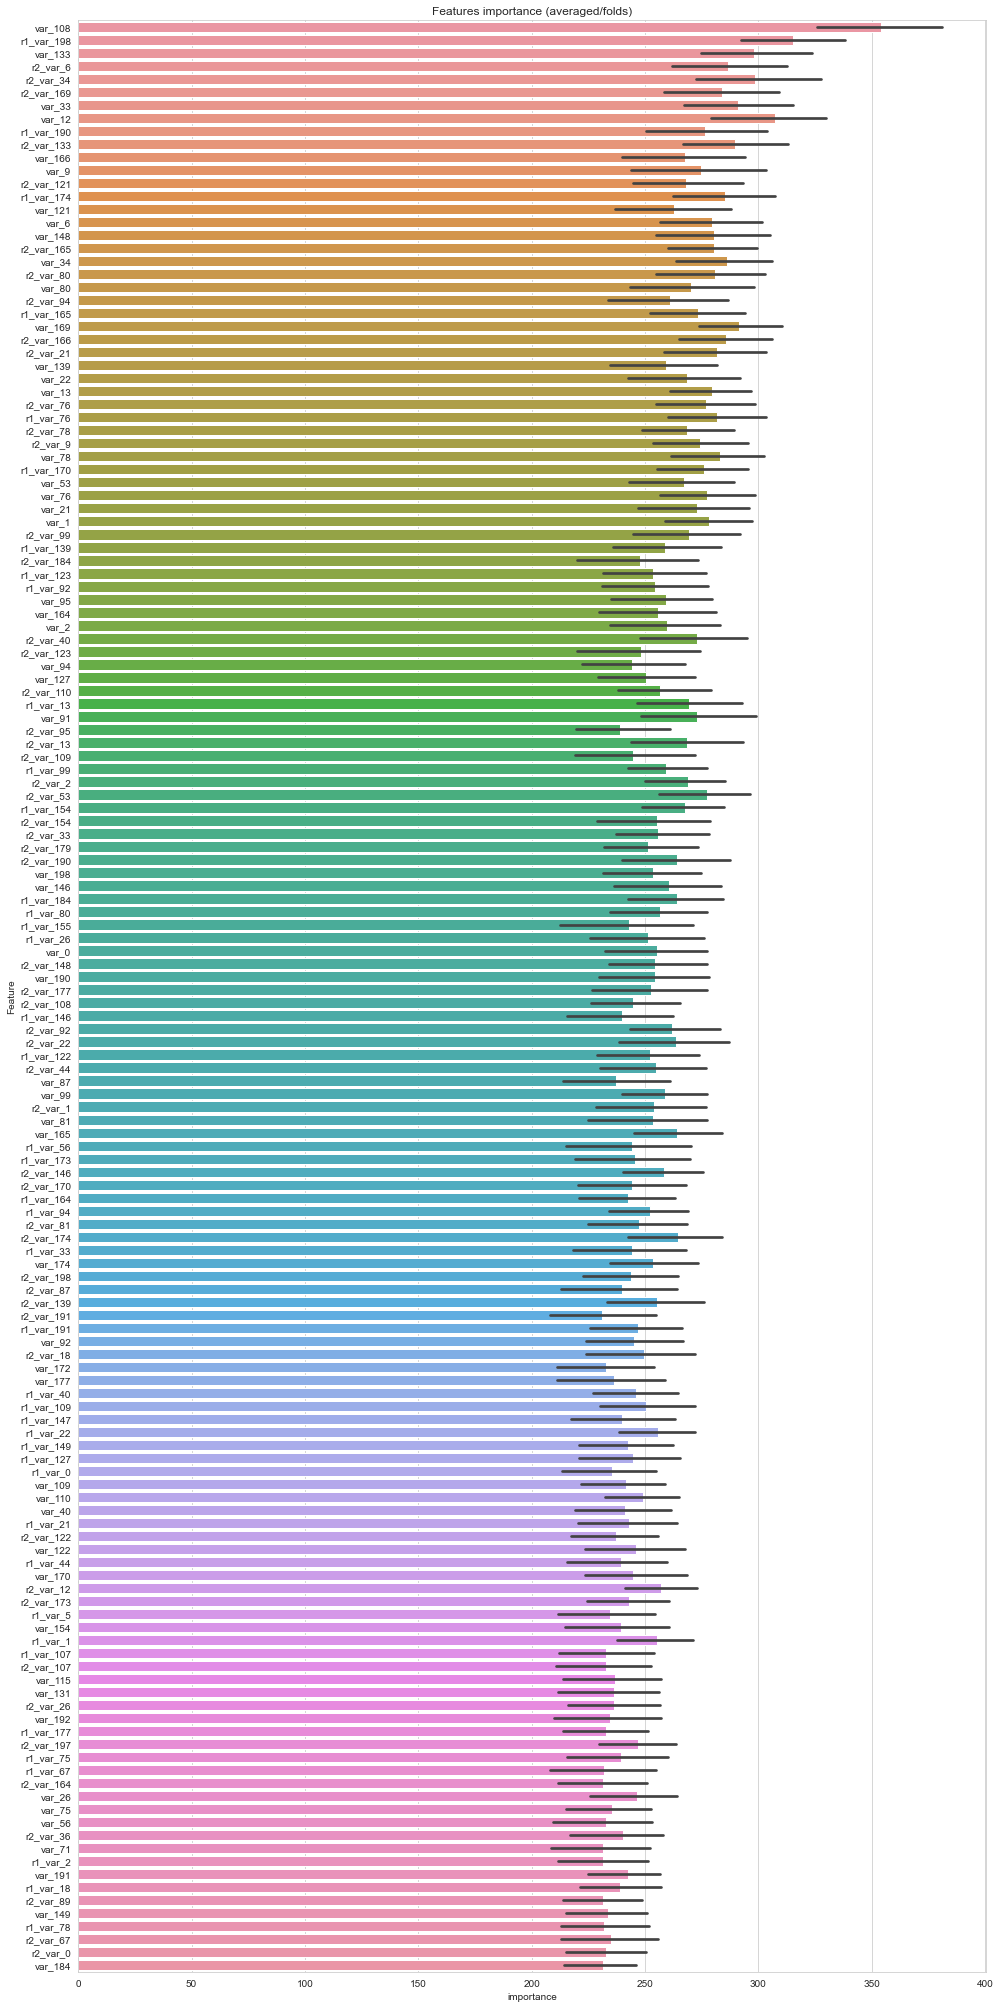

In [26]:
cols = (feature_importance_df[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:150].index)
best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

plt.figure(figsize=(14,28))
sns.barplot(x="importance", y="Feature", data=best_features.sort_values(by="importance",ascending=False))
plt.title('Features importance (averaged/folds)')
plt.tight_layout()
plt.savefig('FI.png')

In [31]:
# test셋의 결과값은 다음과 같다
predictions

array([0.09981404, 0.20480039, 0.20009814, ..., 0.00331929, 0.08742062,
       0.04856643])

# Imbalance 해결 - Data Augmentation

In [50]:
5//2, 5/2, 4//2, 4/2

(2, 2.5, 2, 2.0)

In [32]:
def augment(x,y,t=2):
    xs,xn = [],[]
    for i in range(t):
        mask = y>0
        x1 = x[mask].copy()
        ids = np.arange(x1.shape[0])
        for c in range(x1.shape[1]):
            np.random.shuffle(ids)
            x1[:,c] = x1[ids][:,c]
        xs.append(x1)

    for i in range(t//2):
        mask = y==0
        x1 = x[mask].copy()
        ids = np.arange(x1.shape[0])
        for c in range(x1.shape[1]):
            np.random.shuffle(ids)
            x1[:,c] = x1[ids][:,c]
        xn.append(x1)

    xs = np.vstack(xs)
    xn = np.vstack(xn)
    ys = np.ones(xs.shape[0])
    yn = np.zeros(xn.shape[0])
    x = np.vstack([x,xs,xn])
    y = np.concatenate([y,ys,yn])
    return x,y

## 모델링을 하기 위한 데이터셋 준비

### fold=10으로 split 하고
* X_train.shape, y_train.shape, X_valid.shape, y_valid.shape
* ((180000, 624), (180000,), (20000, 624), (20000,))

In [35]:
random_state = 44000
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=random_state)
oof = train_df[['ID_code', 'target']]
oof['predict'] = 0
predictions = test_df[['ID_code']]
val_aucs = []
feature_importance_df = pd.DataFrame()

### 피쳐명 리스트와 테스트셋 만들어 놓고

In [36]:
features = [col for col in train_df.columns if col not in ['target', 'ID_code']]
X_test = test_df[features].values

### fold=10 만큼 for 루프 돌면서 모델링
* 5번 loop 돌며 augment
* augment 방법은 y=1을 램덤하게 2배 더 만드는 것임
* augment 후, 378089 rows × 624 columns
* y=1일때, 54,267개
* y=0일때, 323,822
* auc 가 0.902873, 0.90308, 0.902917 ... 으로, 0.9 대비 소폭 상승

In [60]:
for fold, (trn_idx, val_idx) in enumerate(skf.split(train_df, train_df['target'])):
    X_train, y_train = train_df.iloc[trn_idx][features], train_df.iloc[trn_idx]['target']
    X_valid, y_valid = train_df.iloc[val_idx][features], train_df.iloc[val_idx]['target']
    
    N = 5
    p_valid,yp = 0,0
    for i in range(N):
        X_t, y_t = augment(X_train.values, y_train.values)
        X_t = pd.DataFrame(X_t)
        X_t = X_t.add_prefix('var_')
    
        trn_data = lgb.Dataset(X_t, label=y_t)
        val_data = lgb.Dataset(X_valid, label=y_valid)
        evals_result = {}
        lgb_clf = lgb.train(param,
                        trn_data,
                        100000,
                        valid_sets = [trn_data, val_data],
                        early_stopping_rounds=3000,
                        verbose_eval = 1000,
                        evals_result=evals_result
                       )
        p_valid += lgb_clf.predict(X_valid)
        yp += lgb_clf.predict(X_test)
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = features
    fold_importance_df["importance"] = lgb_clf.feature_importance()
    fold_importance_df["fold"] = fold + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    oof['predict'][val_idx] = p_valid/N
    val_score = roc_auc_score(y_valid, p_valid)
    val_aucs.append(val_score)
    
    predictions['fold{}'.format(fold+1)] = yp/N

[LightGBM] [Info] Number of positive: 54267, number of negative: 323822
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010526 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141388
[LightGBM] [Info] Number of data points in the train set: 378089, number of used features: 623
Training until validation scores don't improve for 3000 rounds
[1000]	training's auc: 0.924253	valid_1's auc: 0.858303
[2000]	training's auc: 0.941512	valid_1's auc: 0.877768
[3000]	training's auc: 0.950041	valid_1's auc: 0.887903
[4000]	training's auc: 0.95479	valid_1's auc: 0.893276
[5000]	training's auc: 0.958024	valid_1's auc: 0.896919
[6000]	training's auc: 0.960541	valid_1's auc: 0.899144
[7000]	training's auc: 0.962403	valid_1's auc: 0.900713
[8000]	training's auc: 0.963966	valid_1's auc: 0.901603
[9000]	training's auc: 0.965315	valid_1's auc: 0.902172
[1

[4000]	training's auc: 0.954879	valid_1's auc: 0.88615
[5000]	training's auc: 0.958188	valid_1's auc: 0.890602
[6000]	training's auc: 0.960661	valid_1's auc: 0.893542
[7000]	training's auc: 0.962504	valid_1's auc: 0.895609
[8000]	training's auc: 0.964074	valid_1's auc: 0.897015
[9000]	training's auc: 0.965404	valid_1's auc: 0.897956
[10000]	training's auc: 0.966639	valid_1's auc: 0.898603
[11000]	training's auc: 0.96779	valid_1's auc: 0.89911
[12000]	training's auc: 0.968903	valid_1's auc: 0.899532
[13000]	training's auc: 0.969987	valid_1's auc: 0.899742
[14000]	training's auc: 0.971029	valid_1's auc: 0.899943
[15000]	training's auc: 0.972069	valid_1's auc: 0.900091
[16000]	training's auc: 0.973076	valid_1's auc: 0.900216


KeyboardInterrupt: 